In [ ]:
#### CODE FROM EN 577 CLASS ON FORECASTING AND DEMAND COURTESY OF DR SEN GUPTA 

--- Initial Data Preview ---
            Demand
2023-03-31    8000
2023-06-30   13000
2023-09-30   23000
2023-12-31   34000
2024-03-31   10000


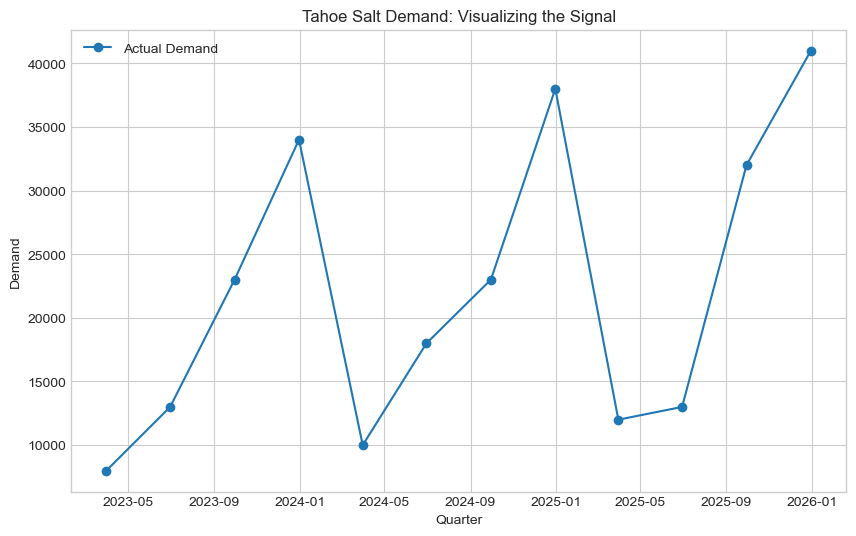


--- Running Augmented Dickey-Fuller (ADF) Test ---
ADF Statistic: -0.5512
p-value: 0.8816
Interpretation: p-value > 0.05. We FAIL to reject H0.
Conclusion: The data is NON-STATIONARY (it has Trend/Seasonality).

--- Calculating Moving Average (N=4) ---
            Demand     MA_4
2023-03-31    8000      NaN
2023-06-30   13000      NaN
2023-09-30   23000      NaN
2023-12-31   34000      NaN
2024-03-31   10000  19500.0
2024-06-30   18000  20000.0
2024-09-30   23000  21250.0
2024-12-31   38000  21250.0
2025-03-31   12000  22250.0
2025-06-30   13000  22750.0
2025-09-30   32000  21500.0
2025-12-31   41000  23750.0


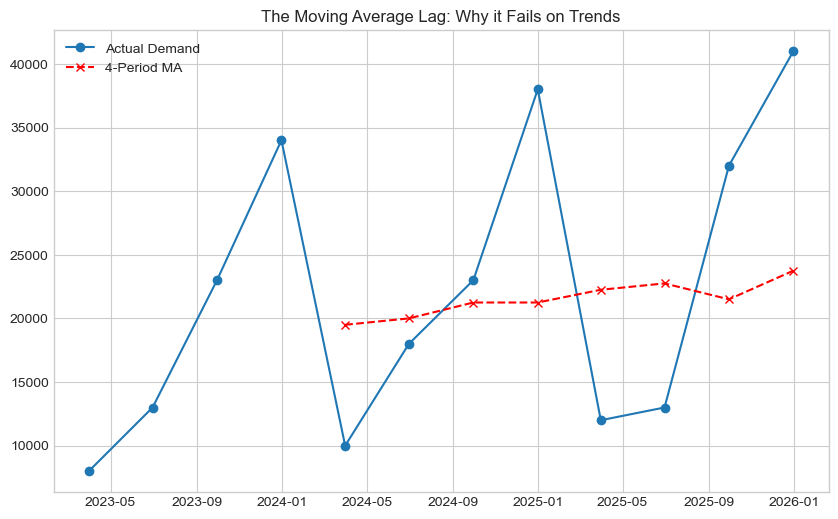


--- Method 1: Simple Exponential Smoothing (SES) ---
Optimal Alpha (Level Smoothing Factor): 0.339

--- Method 2: Holt's Linear Trend Model ---
Alpha (Level): 0.288
Beta (Trend):  0.288

--- Method 3: Holt-Winters (Triple Smoothing) ---
--- Model Parameters ---
Alpha (Level): 0.150
Beta (Trend):  0.123
Gamma (Seas):  0.004

--- Future Forecast (Next 4 Periods) ---
2026-03-31    13956.042216
2026-06-30    19427.600129
2026-09-30    29967.502754
2026-12-31    41472.457452
Freq: Q-DEC, dtype: float64


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


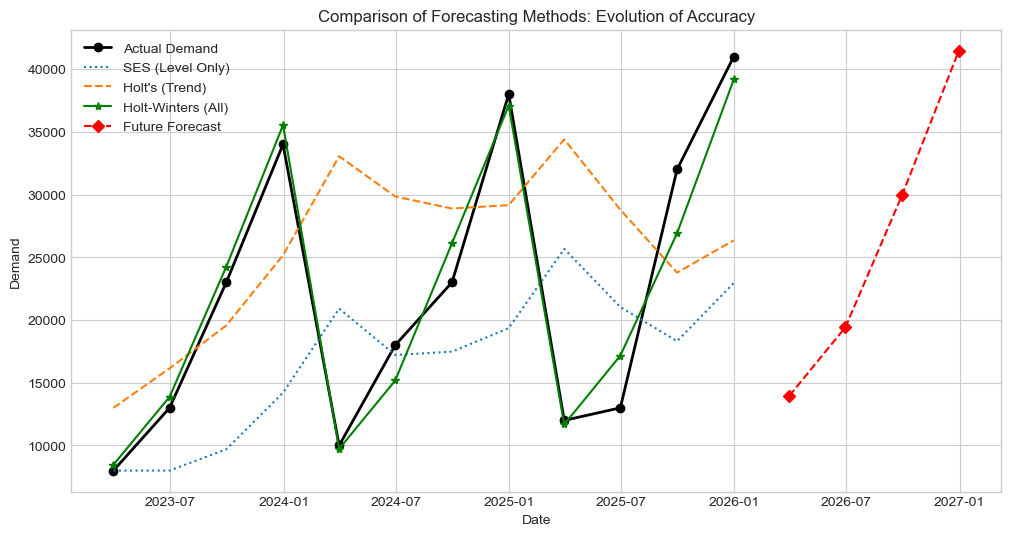

In [1]:

# -----------------------------------------------------------------------------
# SETUP: Import Libraries and Load Data
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf

# Use a clean plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# -----------------------------------------------------------------------------
# BLOCK 1: Load the Data (Tahoe Salt Example from Chopra)
# -----------------------------------------------------------------------------
# Hardcoded data from the textbook example
data = {
    'Period': range(1, 13),
    'Demand': [8000, 13000, 23000, 34000, 10000, 18000, 23000, 38000, 12000, 13000, 32000, 41000]
}

# Create a proper Datetime Index (Quarterly starting from 2023)
index = pd.date_range(start='2023-01-01', periods=12, freq='Q')
df = pd.DataFrame(data['Demand'], index=index, columns=['Demand'])

print("--- Initial Data Preview ---")
print(df.head())

# Visual Inspection of the Data
plt.figure(figsize=(10, 6))
plt.plot(df['Demand'], marker='o', label='Actual Demand')
plt.title("Tahoe Salt Demand: Visualizing the Signal")
plt.xlabel("Quarter")
plt.ylabel("Demand")
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# BLOCK 2: Exploratory Data Analysis (EDA) - Stationarity Test
# Lecture Concept: "The Prerequisite: Stationarity"
# -----------------------------------------------------------------------------
print("\n--- Running Augmented Dickey-Fuller (ADF) Test ---")

# The Null Hypothesis (H0): The data is non-stationary (has a unit root).
# We want to REJECT H0 to prove stationarity.
result = adfuller(df['Demand'])

print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] > 0.05:
    print("Interpretation: p-value > 0.05. We FAIL to reject H0.")
    print("Conclusion: The data is NON-STATIONARY (it has Trend/Seasonality).")
else:
    print("Interpretation: p-value <= 0.05. We REJECT H0.")
    print("Conclusion: The data is STATIONARY.")

# -----------------------------------------------------------------------------
# BLOCK 3: The Baseline - Moving Average
# Lecture Concept: "Baseline: Moving Average" & "The Lag"
# -----------------------------------------------------------------------------
print("\n--- Calculating Moving Average (N=4) ---")

# N=4 Moving Average
# We use shift(1) because we can only use PAST data (t-1, t-2...) to forecast t.
df['MA_4'] = df['Demand'].rolling(window=4).mean().shift(1)

print(df[['Demand', 'MA_4']])

# Visualization: Showing the Lag
plt.figure(figsize=(10, 6))
plt.plot(df['Demand'], marker='o', label='Actual Demand')
plt.plot(df['MA_4'], marker='x', linestyle='--', color='red', label='4-Period MA')
plt.title("The Moving Average Lag: Why it Fails on Trends")
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# BLOCK 4: Simple Exponential Smoothing (SES)
# Lecture Concept: "The Memory Models" (Level Only)
# -----------------------------------------------------------------------------
print("\n--- Method 1: Simple Exponential Smoothing (SES) ---")

# Initialize the model
# 'optimized=True' tells statsmodels to find the alpha that minimizes error (SSE)
ses_model = SimpleExpSmoothing(df['Demand']).fit(optimized=True)

print(f"Optimal Alpha (Level Smoothing Factor): {ses_model.params['smoothing_level']:.3f}")

# Store results
df['SES'] = ses_model.fittedvalues

# -----------------------------------------------------------------------------
# BLOCK 5: Holt's Linear Trend Model
# Lecture Concept: "Chasing a Moving Target" (Level + Trend)
# -----------------------------------------------------------------------------
print("\n--- Method 2: Holt's Linear Trend Model ---")

# Holt's model adds a Trend component
holt_model = Holt(df['Demand']).fit(optimized=True)

print(f"Alpha (Level): {holt_model.params['smoothing_level']:.3f}")
print(f"Beta (Trend):  {holt_model.params['smoothing_trend']:.3f}")

# Store results
df['Holt'] = holt_model.fittedvalues

# -----------------------------------------------------------------------------
# BLOCK 6: Holt-Winters (Triple Smoothing)
# Lecture Concept: "The Complete Picture" (Level + Trend + Seasonality)
# -----------------------------------------------------------------------------
print("\n--- Method 3: Holt-Winters (Triple Smoothing) ---")

# Configuration for Tahoe Salt:
# 1. Trend is Additive (Linear growth)
# 2. Seasonality is Additive (Textbook assumption, though Multiplicative often better for real sales)
# 3. Frequency = 4 (Quarterly data)
hw_model = ExponentialSmoothing(
    df['Demand'],
    trend='add',
    seasonal='add',
    seasonal_periods=4
).fit()

# Store fitted values (in-sample forecast)
df['HoltWinters'] = hw_model.fittedvalues

# Generate FUTURE Forecast (Out-of-Sample)
# Forecast next 4 quarters (1 year)
future_forecast = hw_model.forecast(4)

print("--- Model Parameters ---")
print(f"Alpha (Level): {hw_model.params['smoothing_level']:.3f}")
print(f"Beta (Trend):  {hw_model.params['smoothing_trend']:.3f}")
print(f"Gamma (Seas):  {hw_model.params['smoothing_seasonal']:.3f}")

print("\n--- Future Forecast (Next 4 Periods) ---")
print(future_forecast)

# -----------------------------------------------------------------------------
# BLOCK 7: Final Comparison Visualization
# -----------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df['Demand'], marker='o', color='black', linewidth=2, label='Actual Demand')
plt.plot(df['SES'], linestyle=':', label='SES (Level Only)')
plt.plot(df['Holt'], linestyle='--', label="Holt's (Trend)")
plt.plot(df['HoltWinters'], marker='*', linestyle='-', color='green', label="Holt-Winters (All)")

# Plot the future forecast
plt.plot(future_forecast, marker='D', color='red', linestyle='--', label='Future Forecast')

plt.title("Comparison of Forecasting Methods: Evolution of Accuracy")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.show()
